<h1><h1>Pre-trained-Models with PyTorch </h1>


In this lab, you will use pre-trained models to classify between the negative and positive samples; you will be provided with the dataset object. The particular pre-trained model will be resnet18; you will have three questions: 

<ul>
<li>change the output layer</li>
<li> train the model</li> 
<li>  identify  several  misclassified samples</li> 
 </ul>
You will take several screenshots of your work and share your notebook. 


<h2>Table of Contents</h2>


<h2 id="download_data">Download Data</h2>


Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:


In [2]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

--2021-05-26 05:47:28--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

Positive_tensors.zi 100%[===================>]   2.42G  36.6MB/s    in 70s     

2021-05-26 05:48:38 (35.4 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [3]:
!unzip -q Positive_tensors.zip 

In [4]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2021-05-26 05:51:57--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

Negative_tensors.zi 100%[===================>]   1.97G  36.3MB/s    in 60s     

2021-05-26 05:52:57 (33.7 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



We will install torchvision:


In [5]:
!pip install torchvision

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 17.4 MB 13.9 MB/s eta 0:00:01
     |████████████████████████████████| 804.1 MB 1.8 kB/s  eta 0:00:01MB/s eta 0:00:09:00:07
  Attempting uninstall: torch
    Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [100]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [101]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.


In [102]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory=""
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [103]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


<h2 id="Question_1">Question 1</h2>


<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [104]:
# Step 1: Load the pre-trained model resnet18

# Type your code here
model=models.resnet18(pretrained=True)

<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [105]:
# Step 2: Set the parameter cannot be trained for the pre-trained model
for param in model.parameters():
    param.requires_grad=False

# Type your code here

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [106]:
model.fc=nn.Linear(512,2)

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [107]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train the Model


<b>Step 1</b>: Create a cross entropy criterion function 


In [108]:
# Step 1: Create the loss function

# Type your code here
criterion=nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [109]:
train_loader=DataLoader(dataset=train_dataset,batch_size=100)
validation_loader=DataLoader(dataset=validation_dataset,batch_size=100)

<b>Step 3</b>: Use the following optimizer to minimize the loss 


In [110]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

In [111]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [19]:
len(train_dataset)/100

300.0

<!--Empty Space for separating topics-->


 calculating  the accuracy on the validation data for one epoch.


In [112]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs
i=0
j=0
Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    for x, y in train_loader:
        i+=1

        model.train() 
        #clear gradient 
        optimizer.zero_grad()
     
        #make a prediction 
        yhat=model(x)
   
        # calculate loss 
        loss=criterion(yhat,y)
    
        # calculate gradients of parameters 
        loss.backward()
        
        # update parameters 
        optimizer.step()
        
        loss_list.append(loss.data)
        print(i,loss.data)
    correct=0
    for x_test, y_test in validation_loader:
        j+=1
        # set model to eval 
        model.eval()
       
        #make a prediction 
        z=model(x_test)
        
        #find max
        _,yhat=torch.max(z.data,1)
       
       
        #Calculate misclassified  samples in mini-batch 
        correct+=(yhat==y_test).sum().item()
        print(j)
        
   
    accuracy=correct/N_test
    accuracy_list.append(accuracy)



1 tensor(0.7238)
2 tensor(0.6569)
3 tensor(0.6293)
4 tensor(0.5898)
5 tensor(0.5623)
6 tensor(0.4928)
7 tensor(0.4898)
8 tensor(0.4632)
9 tensor(0.4263)
10 tensor(0.4072)
11 tensor(0.3466)
12 tensor(0.3616)
13 tensor(0.3294)
14 tensor(0.3591)
15 tensor(0.3386)
16 tensor(0.2773)
17 tensor(0.2492)
18 tensor(0.2913)
19 tensor(0.2702)
20 tensor(0.2198)
21 tensor(0.2264)
22 tensor(0.2867)
23 tensor(0.2239)
24 tensor(0.1915)
25 tensor(0.1804)
26 tensor(0.1625)
27 tensor(0.1782)
28 tensor(0.1658)
29 tensor(0.1450)
30 tensor(0.1467)
31 tensor(0.1409)
32 tensor(0.1643)
33 tensor(0.1503)
34 tensor(0.1710)
35 tensor(0.1315)
36 tensor(0.1204)
37 tensor(0.1268)
38 tensor(0.1409)
39 tensor(0.1198)
40 tensor(0.1413)
41 tensor(0.1330)
42 tensor(0.1128)
43 tensor(0.1004)
44 tensor(0.1075)
45 tensor(0.1092)
46 tensor(0.1075)
47 tensor(0.1302)
48 tensor(0.0929)
49 tensor(0.0901)
50 tensor(0.0957)
51 tensor(0.0853)
52 tensor(0.0902)
53 tensor(0.0673)
54 tensor(0.1134)
55 tensor(0.0732)
56 tensor(0.0985)
5

<b>the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>


In [113]:
accuracy

0.9944

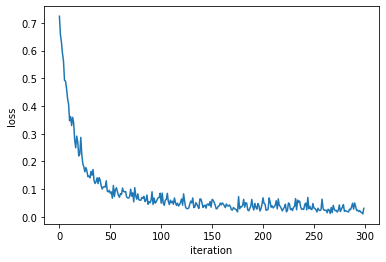

In [114]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


In [115]:
j=0
yhat_list=[]
y_list=[]
yhatt=[]
yy=[]
count=0
for x_test, y_test in validation_loader:
        j+=1
        # set model to eval 
        model.eval()
       
        #make a prediction 
        z=model(x_test)
        #print(z.shape)
        #find max
        _,yhat=torch.max(z.data,1)
        #print(yhat.shape)
        #print(y.shape)
        yhat_list=yhat.tolist()
        y_list=y_test.tolist()
        #print(y_list)
        #print(yhat_list)

        for i in range(0,100):
            if yhat_list[i]!=y_list[i]:
                print('Sample number:',(j-1)*100+i,'The predicted value is',yhat_list[i],'and the real value is',y_list[i])
                count=count+1
                #print(count)
            if count==4:
                break
        if count==4:
            break
            
       
                
            
        #print(j)
        

Sample number: 460 The predicted value is 0 and the real value is 1
Sample number: 484 The predicted value is 0 and the real value is 1
Sample number: 731 The predicted value is 1 and the real value is 0
Sample number: 828 The predicted value is 0 and the real value is 1


## Find the misclassified samples</h2> 


<b>Identify the first four misclassified samples using the validation data:</b>


In [116]:
validation_loaderr=DataLoader(dataset=validation_dataset,batch_size=1)
count=0
j=0
for x_test, y_test in validation_loaderr:
        j+=1
        # set model to eval 
        model.eval()
       
        #make a prediction 
        z=model(x_test)
        
        #find max
        _,yhat=torch.max(z.data,1)

        if yhat !=y_test:
            count=count+1
            #print(count)
            print('sample number',j,'Real value:',y_test.item(),'predicted value:',yhat.item())
        if count==4:
            break




sample number 461 Real value: 1 predicted value: 0
sample number 485 Real value: 1 predicted value: 0
sample number 732 Real value: 0 predicted value: 1
sample number 829 Real value: 1 predicted value: 0


In [99]:
validation_loaderr=DataLoader(dataset=validation_dataset,batch_size=1)
count=0
j=0
for x_test, y_test in validation_loaderr:
        j+=1
        # set model to eval 
        model.eval()
       
        #make a prediction 
        z=model(x_test)
        
        #find max
        _,yhat=torch.max(z.data,1)

        if yhat !=y_test:
            count=count+1
            #print(count)
            print('sample number',j,'Actual value:',y_test,'predicted value:',yhat)
        if count==4:
            break




sample number 461 Actual value: tensor([1]) predicted value: tensor([0])
sample number 485 Actual value: tensor([1]) predicted value: tensor([0])
sample number 732 Actual value: tensor([0]) predicted value: tensor([1])
sample number 829 Actual value: tensor([1]) predicted value: tensor([0])
